In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Plotting functions

def plot_freq_distribution(data_list, bins_count, color):
    plt.hist(data_list, bins=bins_count, density=True, alpha=0.5, color = color)

    plt.title('Distribution plot')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    plt.show()
    
def plot_qq(residuals):
    sm.qqplot(residuals, line = 'q') 
    plt.title('Q-Q Plot')
    plt.show()

def plot_residual_vs_predicted(residuals, predicted_y):
    # Create the plot
    plt.figure(figsize=(10,6))
    sns.scatterplot(x=predicted_y, y=residuals)
    plt.axhline(y=0, color='r', linestyle='--')

    plt.title('Residuals vs. Predicted')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    
    plt.show()

In [26]:
# Functions

def get_correlations(corr_df, intercept_col_name):
    copy_corr_df = corr_df.copy()
    if intercept_col_name in copy_corr_df: copy_corr_df.drop(intercept_col_name, axis = 1, inplace=True)
    
    answers = []

    corr_matrix = corr_df.values
    cols_count = len(corr_matrix)    
    for i in range(cols_count):
        for j in range(i+1, cols_count):
            corr_val = abs(round(corr_matrix[i, j], 2))
            answers.append(corr_val)
    
    return answers

def get_fully_correlated_pairs_set(corr_df):
    # Assuming 'df' is your correlation dataframe
    mask = np.ones(corr_df.shape, dtype=bool)
    np.fill_diagonal(mask, 0)
    filtered_corr_df = corr_df[mask & (corr_df == 1)]
    
    answers = set()

    for index_name in filtered_corr_df.index:
        for column_name in filtered_corr_df.columns:
            if not pd.isnull(filtered_corr_df.loc[index_name, column_name]):
                if ((index_name, column_name) not in answers) \
                    and ((column_name, index_name) not in answers):
                        answers.add((index_name, column_name))
    
    return answers

def inverse_boxcox(boxcox_y, lambda_val):
    if lambda_val == 0: return np.exp(boxcox_y)
    else: return np.power(lambda_val * boxcox_y + 1, 1 / lambda_val)
    
def vif_statsmodels(X, intercept_colname):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    from statsmodels.tools.tools import add_constant
    
    X_copy = X.copy()
    if intercept_colname not in X_copy: X_copy = add_constant(X_copy)
    
    vif = pd.DataFrame()
    vif["variables"] = X_copy.columns
    vif["VIF"] = [variance_inflation_factor(X_copy.values, i) for i in range(X_copy.shape[1])]
    return vif
    
def vif_custom(X, lambdas, intercept_col_name):
    from numpy.linalg import inv
    copy_X = X.copy()
    if intercept_col_name in copy_X: copy_X.drop(intercept_col_name, axis=1, inplace=True)

    n_col = copy_X.shape[1] - 1
    vif = np.zeros((len(lambdas), n_col))

    # Compute correlation matrices
    rxx = copy_X.iloc[:, :n_col].corr().values
    rxy = copy_X.corr().iloc[:n_col, n_col].values

    for i in range(len(lambdas)):
        tmp1 = inv(rxx + lambdas[i] * np.eye(n_col))
        vif[i, :] = np.diag(np.dot(np.dot(tmp1, rxx), tmp1))
    
    vif_df = pd.DataFrame(vif, columns=copy_X.columns[:-1], index=lambdas)
    return vif_df

def find_optimal_ridge_alpha(vif_df, step_size):
    INVALID_LEFT = -2
    INVALID_RIGHT = 2
    
    def check(vif_df, left, right):
        lower_bound_condition = (vif_df.min(axis=COL) >= left)
        upper_bound_condition = (vif_df.max(axis=COL) <= right)
        
        return vif_df[lower_bound_condition & upper_bound_condition].shape[0] > 0
    
    from functools import lru_cache
    @lru_cache(maxsize = None)
    def solve(left, right):
        assert right >= left
        if right - left > 1: return (INVALID_LEFT, INVALID_RIGHT)
        if check(vif_df, left, right): return (left, right)
    
        left_answer = solve(left - step_size, right)
        left_range = left_answer[1] - left_answer[0]
        
        right_answer = solve(left, right + step_size)
        right_range = right_answer[1] - right_answer[0]
        
        both_answer = solve(left - step_size, right + step_size)
        both_range = both_answer[1] - both_answer[0]
        
        min_window = (-2, 2)
        min_range = min_window[1] - min_window[0]

        if left_range < min_range:
            min_range = left_range
            min_window = left_answer
            
        if right_range < min_range:
            min_range = right_range
            min_window = right_answer
            
        if both_range < min_range:
            min_range = both_range
            min_window = both_answer
        
        return min_window
        
    left, right = solve(1, 1)
    return left, right

def calculate_condition_indices(X, intercept_col_name):
    copy_X = X.copy()
    if intercept_col_name in copy_X: copy_X.drop(intercept_col_name, axis=COL, inplace=True)
    
    X_values = copy_X.values
    eigenvalues = np.linalg.eigvals(X_values.T @ X_values)
    
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues_sorted = eigenvalues[sorted_indices]
    
    condition_indices = np.sqrt(eigenvalues_sorted[0] / eigenvalues_sorted)
    condition_indices_rounded = ["{:.4f}".format(idx) for idx in condition_indices]
    
    condition_indices_df = pd.DataFrame({
        'Column Name': X.columns[sorted_indices],
        'Condition Index': condition_indices_rounded
    })
    return condition_indices_df

def get_model_error_assess_df(predicted_y, actual_y):
    results_df = pd.DataFrame()

    results_df['predicted_y'] = np.array(predicted_y)
    results_df['actual_y'] = np.array(actual_y)
    results_df['residuals'] = results_df['predicted_y'] - results_df['actual_y']
    
    return results_df

def get_beta_varcov_matrix(X_train, residuals, intercept_col_name, regularized_lambda = 0):
    copy_X = X_train.copy()
    # if intercept_col_name in copy_X: copy_X.drop(intercept_col_name, axis = 1, inplace=True)
    
    XtX = np.dot(copy_X.T, copy_X)
    XtX_adjusted_inv = np.linalg.inv(XtX + regularized_lambda * np.eye(copy_X.shape[1]))
    residual_variance = np.var(residuals, ddof=copy_X.shape[1])

    beta_variance = residual_variance * ( XtX_adjusted_inv @ XtX @ XtX_adjusted_inv)
    return beta_variance

def inverse_std_intercept(model, X_train, y_train, intercept_col_name):
    copy_X = X_train.copy()
    if intercept_col_name in copy_X: copy_X.drop(intercept_col_name, axis = 1, inplace=True)
    
    std_responsePredictors_ratio = (y_train.std() / copy_X.std())
    model_coef, model_intercept = model.coef_[:-1], model.coef_[-1]
    std_y_x_ratio = y_train.std() / copy_X.std()
    
    return model_intercept * y_train.std() + y_train.mean() - np.sum(model_coef * std_y_x_ratio * copy_X.mean())

def inverse_std_coef(model, X_train, y_train, intercept_col_name):
    copy_X = X_train.copy()
    if intercept_col_name in copy_X: copy_X.drop(intercept_col_name, axis = 1, inplace=True)
    
    std_responsePredictors_ratio = (y_train.std() / copy_X.std())
    model_coef = model.coef_[:-1]
    
    return model_coef * std_responsePredictors_ratio

def get_outliers_influential_points(X, y):
    from scipy.stats import t
    # Calculate the hat matrix
    H = X @ np.linalg.inv(X.T @ X) @ X.T
    
    # Calculate the residuals
    y_hat = H @ y
    residuals = y - y_hat
    
    # Calculate the standard deviation of the residuals
    residual_std = np.sqrt(np.sum(residuals**2) / (X.shape[0] - X.shape[1]))
    
    # Calculate the standard errors
    standard_errors = np.sqrt(np.diag((1 - np.diag(H)) * residual_std**2))
    
    # Calculate the studentized residuals
    studentized_residuals = residuals / standard_errors
    
    # Identify outliers (two-sided test for absolute residuals)
    outliers = np.abs(studentized_residuals) > t.ppf(0.975, df=X.shape[0]-X.shape[1])
    
    # Identify influential points (Cook's distance)
    cooks_distance = residuals**2 / (X.shape[1] * standard_errors**2)
    influential_points = cooks_distance > 4 / (X.shape[0] - X.shape[1])
    
    # Identify leverage points (diagonal elements of the hat matrix)
    leverage_points = np.diag(H) > 2 * X.shape[1] / X.shape[0]
    
    # Print the indices of the outliers, influential points, and leverage points
    print("Outliers: ", np.where(outliers)[0])
    print("Influential points: ", np.where(influential_points)[0])
    print("Leverage points: ", np.where(leverage_points)[0])
    
    return outliers, influential_points, leverage_points

def get_standardize_df(X, intercept_col_name):
    X_copy = X.copy()
    
    non_encoding_colnames = [col for col in X_copy.columns if \
                            X_copy[col].dtype != 'int64' or X_copy[col].nunique() >= 10]
    
    mean_sub_df = X_copy[non_encoding_colnames].mean()
    std_sub_df = X_copy[non_encoding_colnames].std()

    X_copy[non_encoding_colnames] = (X_copy[non_encoding_colnames] - mean_sub_df) / std_sub_df
    X_copy[intercept_col_name] = 0
    
    return X_copy

def detect_outliers_leverage_influential(X_train, y_train):
    copy_X = X_train.copy()
    if 'const' not in copy_X: sm.add_constant(copy_X)
    
    model = sm.OLS(y_train, copy_X)
    results = model.fit()

    # Leverage is calculated as the diagonal of the hat matrix
    influence = results.get_influence()
    leverage = influence.hat_matrix_diag

    # Standardized residuals are used to find outliers
    standardized_residuals = results.resid_pearson

    # Cook's distance is a measure of the influence of each observation
    cooks_d = influence.cooks_distance[0]

    # You can adjust these thresholds as needed
    outlier_threshold = 2
    leverage_threshold = 2*copy_X.shape[1]/copy_X.shape[0]
    cooks_d_threshold = 4/copy_X.shape[0]

    outlier_indices = copy_X.index[np.abs(standardized_residuals) > outlier_threshold]
    high_leverage_indices = copy_X.index[leverage > leverage_threshold]
    influential_point_indices = copy_X.index[cooks_d > cooks_d_threshold]

    return outlier_indices, high_leverage_indices, influential_point_indices

def get_boxcox(y):
    from scipy import stats
    boxcox_y, lambda_val = stats.boxcox(y)
    return boxcox_y, lambda_val

def get_inv_boxcox(y, lambda_val):
    from scipy.special import inv_boxcox
    return inv_boxcox(y, lambda_val)

In [4]:
PATH = '/Users/hoangchu/Downloads/MATH158_Final/Data/cleaned_data.csv'
RESPONSE_COL_NAME = 'price'
ROW = 0
COL = 1

In [5]:
df = pd.read_csv(PATH)

In [6]:
y = df[RESPONSE_COL_NAME]
X = df.drop(RESPONSE_COL_NAME, axis = COL)
X = sm.add_constant(X)

In [7]:
print(X.shape)
print(X.dtypes.unique())

(2751328, 65)
[dtype('float64') dtype('int64')]


In [8]:
from sklearn.model_selection import train_test_split

# If you don’t specify the random_state in your code, then every time you run your code 
# a new random value is generated and the train and test datasets would have different values each time.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
assert y_train.min() <= y_test.min() <= y_test.max() <= y_train.max()

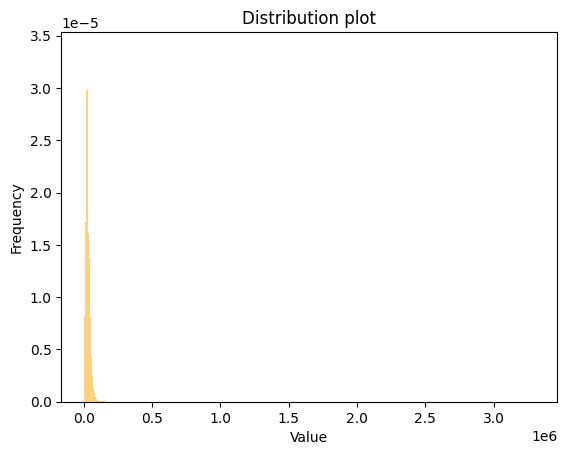

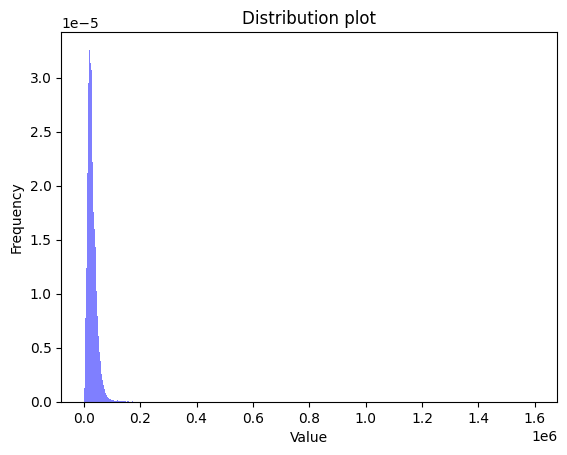

In [9]:
plot_freq_distribution(y_train, 2000, 'orange')
plot_freq_distribution(y_test, 500, 'blue')

# Full Model

5884.33621515109
5879.524153133224


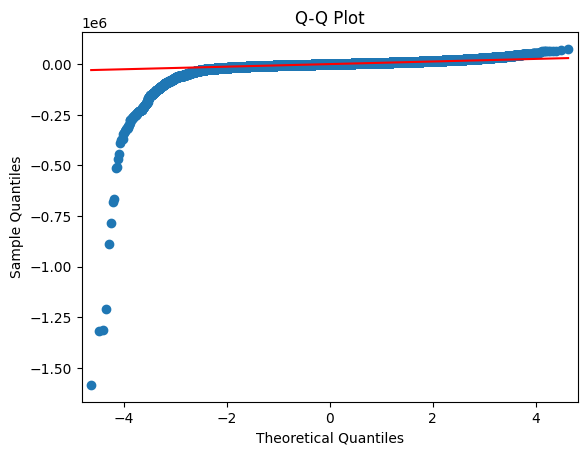

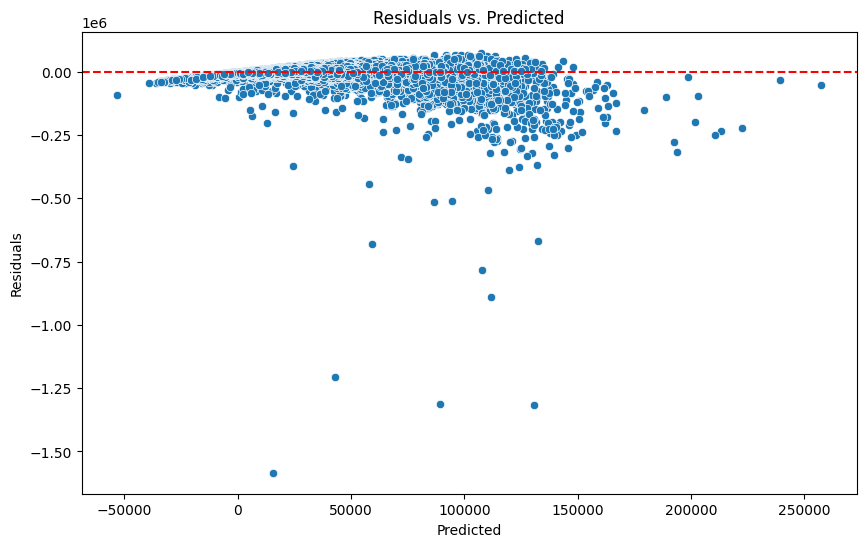

In [10]:
full_linear_model = sm.OLS(y_train, X_train).fit()
full_linear_model.summary()

full_predicted_y_train = full_linear_model.predict(X_train)
full_predicted_y_test = full_linear_model.predict(X_test)

full_results_train_df = get_model_error_assess_df(full_predicted_y_train, y_train)
full_results_train_df['weighted_residuals'] = full_results_train_df['residuals'].apply(lambda x: 1.2 * x if x < 0 else 0.8 * x)
print(np.mean(np.abs(full_results_train_df['weighted_residuals'])))

full_results_df = get_model_error_assess_df(full_predicted_y_test, y_test)
full_results_df['weighted_residuals'] = full_results_df['residuals'].apply(lambda x: 1.2 * x if x < 0 else 0.8 * x)
print(np.mean(np.abs(full_results_df['weighted_residuals'])))

plot_qq(full_results_df['residuals'])
plot_residual_vs_predicted(full_results_df.residuals, full_results_df['predicted_y'])

In [11]:
# from scipy import stats
# _, boxcox_lambda = stats.boxcox(y)
# boxcox_lambda = round(boxcox_lambda, 2)

# assert all(y_train > 0) and all(y_test > 0)
# boxcox_y_train = (y_train**boxcox_lambda - 1) / boxcox_lambda
# boxcox_y_test = (y_test**boxcox_lambda - 1) / boxcox_lambda
# plot_freq_distribution(boxcox_y_train, 200, 'orange')
# plot_freq_distribution(boxcox_y_test, 50, 'blue')

In [12]:
X_train_corr_df = X_train.corr()

In [13]:
fully_connected_col_pairs = get_fully_correlated_pairs_set(X_train_corr_df)
for fully_connected_col_pair in fully_connected_col_pairs:
    col1, col2 = fully_connected_col_pair
    if col1 in X_train.columns: X_train.drop(col1, inplace=True, axis=COL)
print(fully_connected_col_pairs)

{('is_wheel_system_display_Front-Wheel Drive', 'is_wheel_system_FWD'), ('is_wheel_system_display_Rear-Wheel Drive', 'is_wheel_system_RWD'), ('is_wheel_system_display_4X2', 'is_wheel_system_4X2'), ('is_wheel_system_display_Four-Wheel Drive', 'is_wheel_system_4WD')}


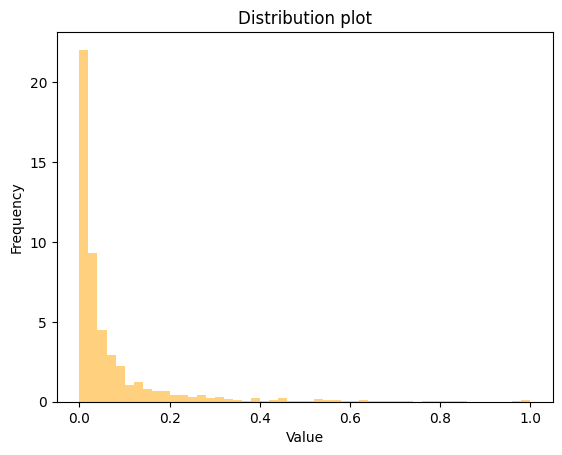

In [14]:
X_train_corrs = get_correlations(X_train_corr_df, 'const')
plot_freq_distribution(X_train_corrs, 50, 'orange')

In [15]:
std_X_train = get_standardize_df(X_train, 'const')
std_y_train = (y_train - y_train.mean()) / y_train.std()

In [35]:
def solve_quadratic(a, b, c):
    # Calculate the discriminant
    D = b**2 - 4*a*c
    
    # Compute the two solutions
    sol1 = (-b - np.sqrt(D)) / (2*a)
    sol2 = (-b + np.sqrt(D)) / (2*a)
    
    return sol1, sol2

In [31]:
vif_table = vif_custom(X_train, np.arange(0, 2, .01), 'const')

In [37]:
vif_orig = pd.DataFrame(columns=vif_table.columns, index=np.arange(0, 2, .01))

In [42]:
for col in vif_orig.T.columns:
    a = vif_table.T[col]
    b = 2 * a * col
    c = (a ** 2) * col
    sol1, sol2 = solve_quadratic(a, b, c)
    print(1 / sol1, 1 / sol2)

back_legroom                          -inf
city                                  -inf
daysonmarket                          -inf
engine_displacement                   -inf
engine_type                           -inf
front_legroom                         -inf
fuel_tank_volume                      -inf
height                                -inf
horsepower                            -inf
latitude                              -inf
length                                -inf
longitude                             -inf
make_name                             -inf
maximum_seating                       -inf
mileage                               -inf
model_name                            -inf
savings_amount                        -inf
seller_rating                         -inf
wheelbase                             -inf
width                                 -inf
year                                  -inf
is_body_type_Sedan                    -inf
is_body_type_Coupe                    -inf
is_body_typ

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encounte

# LASSO AIC

In [16]:
from sklearn.linear_model import LassoLarsIC
aic_lasso_model = LassoLarsIC(criterion="aic", positive=True, fit_intercept=False).fit(std_X_train, std_y_train)

In [17]:
aic_lasso_model.coef_

array([0.        , 0.02816272, 0.        , 0.06455594, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.56012257,
       0.01053765, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00860666, 0.04817374, 0.        ,
       0.        , 0.42275174, 0.        , 0.24492657, 0.        ,
       0.08130751, 0.        , 0.0664568 , 0.        , 0.95360198,
       0.62301276, 0.32759518, 0.        , 0.18497803, 0.        ,
       1.0689295 , 0.03593303, 0.        , 0.12244019, 0.21511208,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03146625, 0.03211201, 0.02832203, 0.        ,
       0.16436449, 0.        , 0.14900645, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [18]:
lassoAIC_stayed_columns = list(X_train.columns[aic_lasso_model.coef_ != 0])
if 'const' not in lassoAIC_stayed_columns: lassoAIC_stayed_columns.append('const')

lassoAIC_X_train = X_train[lassoAIC_stayed_columns]
lassoAIC_X_test = X_test[lassoAIC_stayed_columns]

print(lassoAIC_stayed_columns)
lassoAIC_linear_model = sm.OLS(y_train, lassoAIC_X_train).fit()
lassoAIC_linear_model.summary()

['back_legroom', 'daysonmarket', 'horsepower', 'latitude', 'savings_amount', 'seller_rating', 'year', 'is_body_type_Coupe', 'is_body_type_Wagon', 'is_body_type_Hatchback', 'is_body_type_Convertible', 'is_fuel_type_Diesel', 'is_fuel_type_Biodiesel', 'is_fuel_type_Hybrid', 'is_fuel_type_Propane', 'is_transmission_M', 'is_transmission_Dual Clutch', 'is_listing_color_YELLOW', 'is_listing_color_ORANGE', 'is_listing_color_BROWN', 'is_listing_color_GOLD', 'is_listing_color_GREEN', 'is_listing_color_PINK', 'const']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                 1.173e+05
Date:                Thu, 07 Dec 2023   Prob (F-statistic):               0.00
Time:                        23:30:38   Log-Likelihood:            -2.3915e+07
No. Observations:             2201062   AIC:                         4.783e+07
Df Residuals:                 2201038   BIC:                         4.783e+07
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
back_legroom                  190.1197      3.203     59.365      0.000     183.843     196.397
daysonmarket                   11.2288      0.079    142.194      0.000      11.074      11.384
horsepower                    117.8298      0.110   1071.914      0.000     117.614     118.045
latitude                       41.2623      1.725     23.919      0.000      37.881      44.643
savings_amount                  0.1501      0.008     17.882      0.000       0.134       0.167
seller_rating                1782.6587     16.888    105.556      0.000    1749.558    1815.759
year                         2192.5593      2.502    876.438      0.000    2187.656    2197.463
is_body_type_Coupe           5464.7633     62.785     87.040      0.000    5341.708    5587.819
is_body_type_Wagon           2227.8246     78.390     28.420      0.000    2074.182    2381.467
is_body_type_Hatchback       1936.8753     54.539     35.513      0.000    1829.980    2043.771
is_body_type_Convertible     1.887e+04     94.115    200.494      0.000    1.87e+04    1.91e+04
is_fuel_type_Diesel          1.251e+04     70.631    177.073      0.000    1.24e+04    1.26e+04
is_fuel_type_Biodiesel       6924.7881     95.816     72.271      0.000    6736.991    7112.585
is_fuel_type_Hybrid          4129.9293     54.497     75.782      0.000    4023.117    4236.742
is_fuel_type_Propane          2.14e+04   5663.239      3.778      0.000    1.03e+04    3.25e+04
is_transmission_M            1156.4888     70.158     16.484      0.000    1018.982    1293.995
is_transmission_Dual Clutch  2656.4145    141.651     18.753      0.000    2378.783    2934.046
is_listing_color_YELLOW      4498.0535    226.100     19.894      0.000    4054.906    4941.201
is_listing_color_ORANGE      1213.1855    140.617      8.628      0.000     937.582    1488.789
is_listing_color_BROWN       1362.1479    100.230     13.590      0.000    1165.701    1558.595
is_listing_color_GOLD        1326.5057    145.888      9.093      0.000    1040.571    1612.441
is_listing_color_GREEN       3766.3748     96.514     39.024      0.000    3577.211    3955.539
is_listing_color_PINK        3159.3926   1381.771      2.286      0.022     451.170    5867.615
const                       -4.442e+06   5041.844   -881.000      0.000   -4.45e+06   -4.43e+06
==============================================================================
Omnibus:                  6660238.102   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):    5742494990247.300
Skew:                          43.875   Prob(JB):                         0.00
Kurtosis:                    7915.488   Cond. No.                     1.42e+06
==============================================================================

Notes:
[1] Stand

6676.513919260727
6674.282953268183
2201270.1025525206


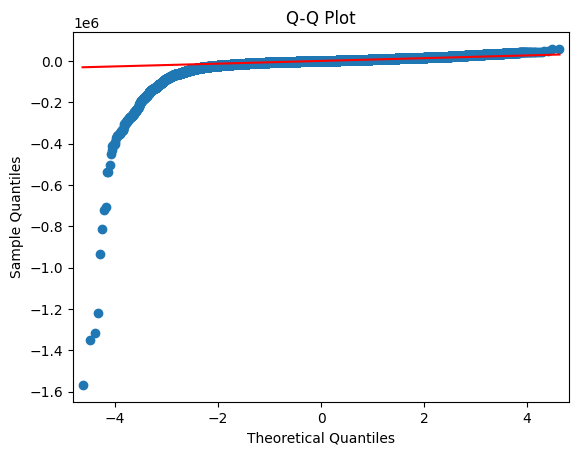

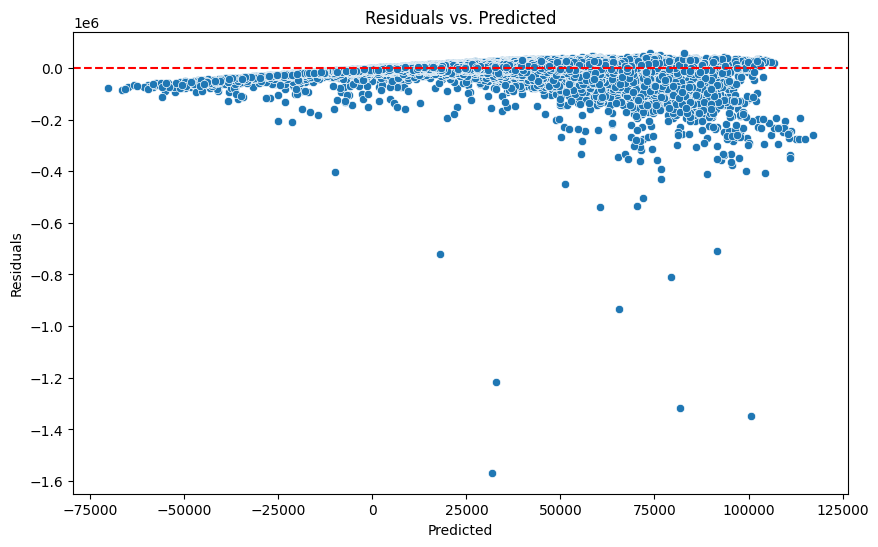

In [19]:
lassoAIC_predicted_y_train = lassoAIC_linear_model.predict(lassoAIC_X_train)
lassoAIC_predicted_y_test = lassoAIC_linear_model.predict(lassoAIC_X_test)

lassoAIC_train_results_df = get_model_error_assess_df(predicted_y=lassoAIC_predicted_y_train, actual_y=y_train)
lassoAIC_train_results_df['weighted_residuals'] = lassoAIC_train_results_df['residuals'].apply(lambda x: 1.2 * x if x < 0 else 0.8 * x)
print(np.mean(np.abs(lassoAIC_train_results_df['weighted_residuals'])))

lassoAIC_results_df = get_model_error_assess_df(predicted_y=lassoAIC_predicted_y_test, actual_y=y_test)
lassoAIC_results_df['weighted_residuals'] = lassoAIC_results_df['residuals'].apply(lambda x: 1.2 * x if x < 0 else 0.8 * x)
print(np.mean(np.abs(lassoAIC_results_df['weighted_residuals'])))

lassoAIC_beta_varcov_matrix = get_beta_varcov_matrix(lassoAIC_X_train, lassoAIC_results_df.residuals, 'const')
print(np.mean(np.diag(lassoAIC_beta_varcov_matrix)))

plot_qq(lassoAIC_results_df['residuals'])
plot_residual_vs_predicted(lassoAIC_results_df.residuals, lassoAIC_results_df['predicted_y'])

# Ridge

https://stats.stackexchange.com/questions/74622/converting-standardized-betas-back-to-original-variables

In [20]:
lamdas = np.arange(1, 100, 1.1)
lassoAIC_vif_df, ridge_beta_df = vif_custom(lassoAIC_X_train, lamdas, 'const')

left, right = find_optimal_ridge_alpha(lassoAIC_vif_df, .01)
lower_bound_ridge_condition = (lassoAIC_vif_df.min(axis=COL) >= left)
upper_bound_ridge_condition = (lassoAIC_vif_df.max(axis=COL) <= right)
lassoAIC_ridge_alpha = lassoAIC_vif_df[lower_bound_ridge_condition & upper_bound_ridge_condition].index[0]
print(f"lassoAIC_ridge_alpha = {lassoAIC_ridge_alpha}")

std_lassoAIC_X_train = get_standardize_df(lassoAIC_X_train, 'const')

from sklearn.linear_model import Ridge
lassoAIC_ridge_model = Ridge(alpha=lassoAIC_ridge_alpha, fit_intercept = False).fit(std_lassoAIC_X_train, std_y_train)

estimated_intercept = inverse_std_intercept(lassoAIC_ridge_model, lassoAIC_X_train, y_train, 'const')
esimated_coef = inverse_std_coef(lassoAIC_ridge_model, lassoAIC_X_train, y_train, 'const')

lassoAIC_ridge_alpha = 1.0


11654.224957842735
11665.973116707955
3848924.266325016


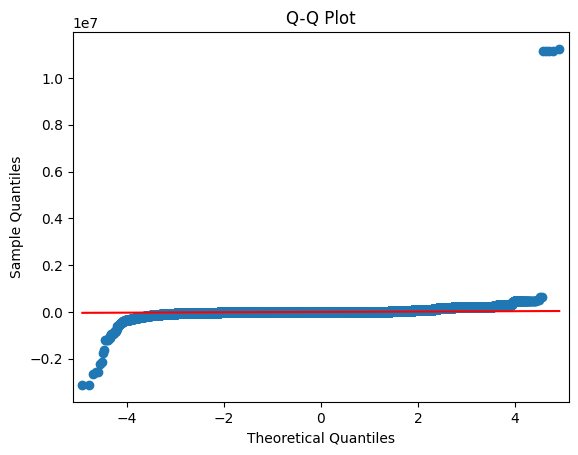

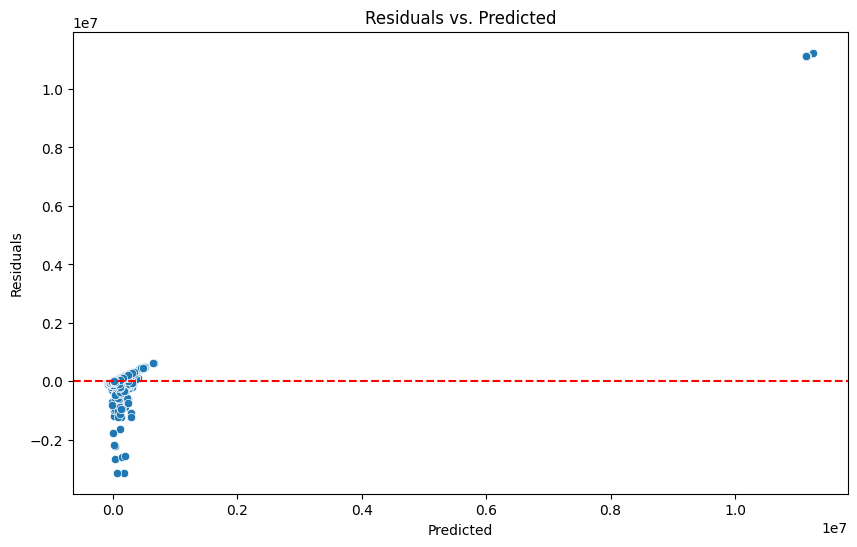

In [21]:
ridge_predicted_y_train = (lassoAIC_X_train.drop('const', axis=1) @ esimated_coef) + estimated_intercept
ridge_predicted_y_test = (lassoAIC_X_test.drop('const', axis=1) @ esimated_coef) + estimated_intercept

ridge_results_df = get_model_error_assess_df(predicted_y=ridge_predicted_y_test, actual_y=y_test)
ridge_results_df['weighted_residuals'] = ridge_results_df['residuals'].apply(lambda x: 1.2 * x if x < 0 else 0.8 * x)
print(np.mean(np.abs(ridge_results_df['weighted_residuals'])))

ridge_results_train_df = get_model_error_assess_df(predicted_y=ridge_predicted_y_train, actual_y=y_train)
ridge_results_train_df['weighted_residuals'] = ridge_results_train_df['residuals'].apply(lambda x: 1.2 * x if x < 0 else 0.8 * x)
print(np.mean(np.abs(ridge_results_train_df['weighted_residuals'])))

ridge_beta_varcov_matrix = get_beta_varcov_matrix(std_lassoAIC_X_train, ridge_results_df.residuals, 'const', lassoAIC_ridge_alpha)
print(np.mean(np.diag(ridge_beta_varcov_matrix)))

plot_qq(ridge_results_train_df['residuals'])
plot_residual_vs_predicted(ridge_results_train_df.residuals, ridge_results_train_df['predicted_y'])

# Influential

62.36832378488265
28.707491899322488
10563.58038414039
11654.224957842735
3861803.7231372925


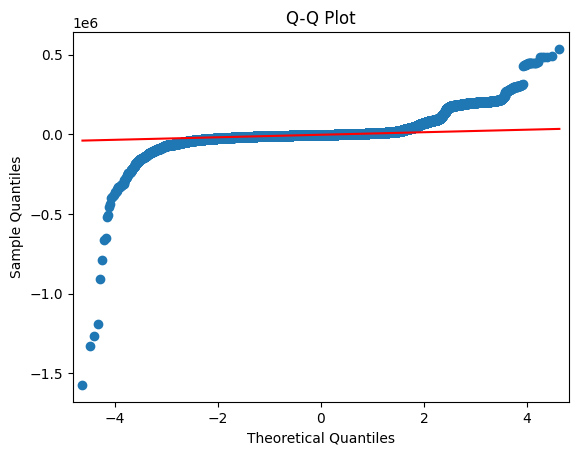

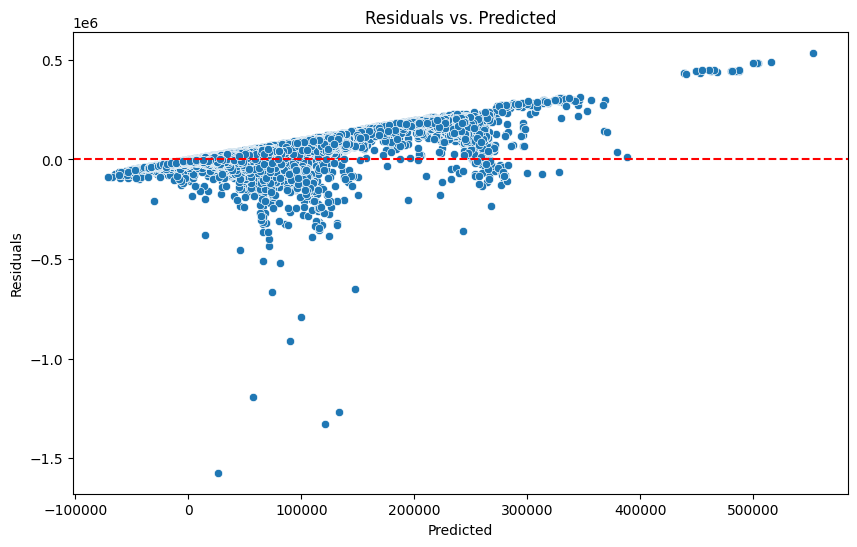

In [22]:
outliers, leverage_points, influential_points = detect_outliers_leverage_influential(lassoAIC_X_train, y_train)

non_influential_outliers = outliers.intersection(influential_points)
print(len(non_influential_outliers) * 100 / len(outliers))

non_influential_leverage_points = leverage_points.intersection(influential_points)
print(len(non_influential_leverage_points) * 100 / len(leverage_points))

temp_y_train = y_train.drop(outliers, inplace=False)
temp_X_train = lassoAIC_X_train.drop(outliers, axis = ROW, inplace=False)

std_temp_X_train = get_standardize_df(temp_X_train, 'const')
std_temp_y_train = (temp_y_train - temp_y_train.mean()) / temp_y_train.std()

######
# bx_y, lambda_val = get_boxcox(temp_y_train)
# print(plot_freq_distribution(bx_y, 50, 'orange'))

# lassoAIC_linear_model = sm.OLS(bx_y, temp_X_train).fit()
# lassoAIC_linear_model.summary()

# lassoAIC_predicted_y_train = lassoAIC_linear_model.predict(temp_X_train)
# lassoAIC_predicted_y_test = lassoAIC_linear_model.predict(lassoAIC_X_test)

# lassoAIC_train_results_df = get_model_error_assess_df(predicted_y=lassoAIC_predicted_y_train, actual_y=temp_y_train)
# lassoAIC_train_results_df['weighted_residuals'] = lassoAIC_train_results_df['residuals'].apply(lambda x: 1.2 * x if x < 0 else 0.8 * x)
# print(np.mean(np.abs(lassoAIC_train_results_df['weighted_residuals'])))

# lassoAIC_results_df = get_model_error_assess_df(predicted_y=lassoAIC_predicted_y_test, actual_y=y_test)
# lassoAIC_results_df['weighted_residuals'] = lassoAIC_results_df['residuals'].apply(lambda x: 1.2 * x if x < 0 else 0.8 * x)
# print(np.mean(np.abs(lassoAIC_results_df['weighted_residuals'])))

# lassoAIC_beta_varcov_matrix = get_beta_varcov_matrix(temp_X_train, lassoAIC_results_df["residuals"], 'const')
# print(np.mean(np.diag(lassoAIC_beta_varcov_matrix)))

# plot_qq(lassoAIC_results_df['residuals'])
# plot_residual_vs_predicted(lassoAIC_results_df.residuals, lassoAIC_results_df['predicted_y'])
######

temp_predicted_y_train = (temp_X_train.drop('const', axis=1) @ esimated_coef) + estimated_intercept
temp_predicted_y_test = (lassoAIC_X_test.drop('const', axis=1) @ esimated_coef) + estimated_intercept
std_temp_X_train = get_standardize_df(temp_X_train, 'const')

temp_train_results_df = get_model_error_assess_df(predicted_y=temp_predicted_y_train, actual_y=temp_y_train)
temp_train_results_df['weighted_residuals'] = temp_train_results_df['residuals'].apply(lambda x: 1.2 * x if x < 0 else 0.8 * x)
print(np.mean(np.abs(temp_train_results_df['weighted_residuals'])))

temp_results_df = get_model_error_assess_df(predicted_y=temp_predicted_y_test, actual_y=y_test)
temp_results_df['weighted_residuals'] = temp_results_df['residuals'].apply(lambda x: 1.2 * x if x < 0 else 0.8 * x)
print(np.mean(np.abs(temp_results_df['weighted_residuals'])))

temp_beta_varcov_matrix = get_beta_varcov_matrix(std_temp_X_train, temp_results_df.residuals, 'const', lassoAIC_ridge_alpha)
print(np.mean(np.diag(temp_beta_varcov_matrix)))

plot_qq(temp_results_df['residuals'])
plot_residual_vs_predicted(temp_results_df.residuals, temp_results_df['predicted_y'])

In [23]:
np.sum(np.sum(lassoAIC_X_train.drop('const', axis=1).corr() - temp_X_train.drop('const', axis=1).corr(), axis=ROW))

0.39646443881971843

# LASSO

In [24]:
from sklearn.linear_model import LassoCV
lasso_model = LassoCV(alphas=None, cv = 10, fit_intercept = False, max_iter=2000).fit(std_X_train, std_y_train)

lasso_stayed_columns = list(X_train.columns[lasso_model.coef_ != 0])
if 'const' not in lasso_stayed_columns: lasso_stayed_columns.append('const')

lasso_X_train = X_train[lasso_stayed_columns]
lasso_X_test = X_test[lasso_stayed_columns]

print(len(lasso_stayed_columns))
lasso_linear_model = sm.OLS(y_train, lasso_X_train).fit()

lasso_predicted_y_train = lasso_linear_model.predict(lasso_X_train)
lasso_predicted_y_test = lasso_linear_model.predict(lasso_X_test)

lasso_results_df = get_model_error_assess_df(predicted_y=lasso_predicted_y_test, actual_y=y_test)
lasso_results_df['weighted_residuals'] = lasso_results_df['residuals'].apply(lambda x: 1.2 * x if x < 0 else 0.8 * x)
print(np.mean(np.abs(lassoAIC_results_df['weighted_residuals'])))

lasso_beta_varcov_matrix = get_beta_varcov_matrix(lasso_X_train, lasso_results_df.residuals, 'const')
print(np.mean(np.diag(lasso_beta_varcov_matrix)))

47
6674.282953268183
1315364.1460372673


In [25]:
lasso_linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                 8.975e+04
Date:                Thu, 07 Dec 2023   Prob (F-statistic):               0.00
Time:                        23:32:56   Log-Likelihood:            -2.3633e+07
No. Observations:             2201062   AIC:                         4.727e+07
Df Residuals:                 2201015   BIC:                         4.727e+07
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
back_legroom                     146.9505      3.023     48.609      0.000     141.025     152.876
city                             106.1639      7.779     13.648      0.000      90.917     121.410
daysonmarket                       3.1135      0.075     41.742      0.000       2.967       3.260
engine_displacement               -3.0670      0.014   -217.374      0.000      -3.095      -3.039
engine_type                    -6369.0973     35.060   -181.664      0.000   -6437.813   -6300.381
front_legroom                    -29.1450      5.716     -5.099      0.000     -40.349     -17.941
fuel_tank_volume                 398.8047      3.721    107.185      0.000     391.512     406.097
horsepower                       150.3402      0.215    700.619      0.000     149.920     150.761
latitude                         -96.9387      1.701    -56.986      0.000    -100.273     -93.605
length                            29.9837      1.960     15.297      0.000      26.142      33.825
longitude                        -31.5093      0.558    -56.473      0.000     -32.603     -30.416
make_name                      -6370.6598     33.597   -189.618      0.000   -6436.509   -6304.810
maximum_seating                 -215.6769      9.137    -23.606      0.000    -233.584    -197.770
mileage                           -0.0869      0.000   -258.870      0.000      -0.088      -0.086
model_name                     -3573.7497     31.559   -113.240      0.000   -3635.604   -3511.895
savings_amount                     1.4129      0.008    167.426      0.000       1.396       1.429
seller_rating                   1509.5431     14.932    101.094      0.000    1480.277    1538.809
wheelbase                        -70.6085      3.015    -23.416      0.000     -76.519     -64.698
width                           -154.7102      1.605    -96.370      0.000    -157.857    -151.564
year                             711.6459      4.229    168.265      0.000     703.357     719.935
is_body_type_Sedan              -104.6804     26.158     -4.002      0.000    -155.949     -53.411
is_body_type_Coupe              1814.2125     64.042     28.329      0.000    1688.693    1939.732
is_body_type_Pickup Truck      -4409.4628     58.976    -74.767      0.000   -4525.054   -4293.872
is_body_type_Wagon              1205.3051     70.613     17.069      0.000    1066.905    1343.705
is_body_type_Hatchback          2338.3131     51.888     45.065      0.000    2236.614    2440.012
is_body_type_Van                3520.5474     80.981     43.474      0.000    3361.828    3679.267
is_body_type_Convertible        1.014e+04     91.846    110.351      0.000    9955.320    1.03e+04
is_fuel_type_Diesel             4952.6654     85.687     57.800      0.000    4784.723    5120.608
is_fuel_type_B